$$p=\frac{\theta RT}{V-b}-\frac{a}{V(V+b)}$$
其中
$$a(T)=0.42748\frac{\theta^2R^2T_{c}^2}{p_c}\alpha(T),b(T)=0.08664\frac{\theta RT_c}{p_c}(\beta(T))=1$$

$p=\frac{\theta RT}{V-0.08664\frac{\theta RT_c}{p_c}}-\frac{0.42748\frac{\theta^2R^2T_c^2}{p_c}\alpha(T)}{V(V+0.08664\frac{\theta RT_c}{p_c})}$

In [38]:
import numpy as np
from math import *
import matplotlib.pyplot as plt
import cmath

R = 8.314
def ALPHA(omega,T,T_c):
	"""
	alpha(T)函数，传入偏心因子，对比温度
	"""
	T_r = T/T_c
	return (1+(0.48+1.574*omega-0.176*omega*omega)*(1-sqrt(T_r)))**2
def SOLVE_THREE(P,Q)->list:
	OMEGA = (-1+(sqrt(3))*1j)/(2)
	l1,l2 = -Q/2+cmath.sqrt((Q/2)**2+(P/3)**3),-Q/2-cmath.sqrt((Q/2)**2+(P/3)**3)
	X1 = l1**(1/3)+l2**(1/3)
	X2 = OMEGA*l1**(1/3)+OMEGA*OMEGA*l2**(1/3)
	X3 = OMEGA*OMEGA*l1**(1/3)+OMEGA*l2**(1/3)
	X = [X1,X2,X3]
	solve_list = []
	for num in X:
		if num.imag == 0: # 实数
			solve_list.append(num.real)
	return solve_list
def getTHETA(p,V,T,T_c,p_c,omega): # θ应为正值
	alpha = ALPHA(omega,T,T_c) # α(T)
	# 取 ax^3+bx^2+cx+d=0
	# 计算a -> 三次方
	A = 0.42748*alpha*0.08664*(R**3*T_c**3)/(p_c**2)
	# 计算b -> 二次方
	B = -0.42748*alpha*(R**2*T_c**2*V)/(p_c)+0.08664**2*p*V*(R**2*T_c**2)/(p_c**2)+0.08664*R*T_c*R*T*V/p_c
	# 计算c -> 一次项
	C = R*T*V*V
	# 计算d -> 常数项
	D = -p*V**3
	# 求解方程 θ^3+pθ+q=0
	P = (3*A*C-B**2)/(3*A*A)
	Q = (27*A*A*D-9*A*B*C+2*B**3)/(27*A**3)
	# Theta = np.array(SOLVE_THREE(P=P,Q=Q))-B/(3*A)
	# return Theta
	Theta = np.roots([A,B,C,D])
	solve_list = []
	for num in Theta:
		if num.imag == 0: # 实数
			solve_list.append(num.real)
	cp = min(solve_list)
	if cp >= 0.5:
		numk = -1
		ma = -1
		for cck in range(len(solve_list)):
			if cck == 0:
				ma = abs(solve_list[cck]-1)
				numk = cck
				continue
			if (abs(solve_list[cck]-1)<ma):
				ma = abs(solve_list[cck]-1)
				numk = cck
		cp = solve_list[numk]
	return cp

In [39]:
sss = getTHETA(221.287*10**5,57.06/(10**6),647.30,647.30,221.287*10**5,0.34486)
print(sss)
print((221.287*10**5*57.06/(10**6)/(R*647.30))*3)

0.7170079453235174
0.7038713624042818


In [40]:
import pandas as pd
def read_excel(filepath,kind):
	excel_file = pd.ExcelFile(filepath)
	active_sheet = excel_file.sheet_names[0]
	df = pd.read_excel(filepath,sheet_name=active_sheet)
	headers = df.columns.tolist()
	if kind == 1: # 列
		columns_data = {}
		for header in headers:
			columns_data[header] = df[header].tolist()
		return columns_data
	elif kind == 0: # 行
		rows_data = []
		for index, row in df.iterrows():
			rows_data.append(row.tolist())
		columns_data = {}
		columns_data[headers[0]] = headers[1:]
		for lists in rows_data:
			columns_data[lists[0]] = lists[1:]
		return columns_data
TIES_OF_MATTER = read_excel('./PVT_data/High precise EOS polar data.xlsx',0)
# Tc K  pc bar(10^5 Pa) Vc cm^3  w
T_C = np.array(TIES_OF_MATTER['Tc(K)'])[0:15] # K
V_C = np.array(TIES_OF_MATTER['Vc(cm3/mol)'][0:15])/(10**6) # m^3
P_C = np.array(TIES_OF_MATTER['Pc(bar)'][0:15])*(10**5) # Pa
M = np.array(TIES_OF_MATTER['M'])[0:15] # g/mol
OMEGA = np.array(TIES_OF_MATTER['w'])[0:15]

In [41]:
ThetaAll = []
PAll = []
VAll = []
TAll = []
for ic in range(1):
	PVT = read_excel('./PVT_WATER/Water PVT NRTL.xlsx',1)
	i = 14
	keys = list(PVT.keys())
	P,V,T = PVT[keys[0]],list(np.array(PVT[keys[2]])/1000),PVT[keys[1]] # 分别是Pa K m^3
	theta_temp,ptemp,vtemp,ttemp = [],[],[],[]
	tc,vc,pc,omega = T_C[i],V_C[i],P_C[i],OMEGA[i]
	for k in range(len(P)):
		p,v,t = P[k],V[k],T[k]
		ptemp.append(p)
		vtemp.append(v)
		ttemp.append(t)
		thetat = getTHETA(p,v,t,tc,pc,omega)
		theta_temp.append(thetat)
	PAll.append(ptemp)
	VAll.append(vtemp)
	TAll.append(ttemp)
	ThetaAll.append(theta_temp)
print(ThetaAll)

[[0.0007790857086418186, 0.002428562031208783, 0.0042268194878906104, 0.0062216476611340445, 0.008493683012713228, 0.011200776911455657, 0.0147539853734625, 0.765860234720888, 0.7658801011534891, 0.7658999571153943, 0.7659198026161451, 0.7659396376652732, 0.765959462272296, 0.7659792764467183, 0.765999080198033, 0.7660188735357181, 0.7660386564692425, 0.766058429008058, 0.7660781911616058, 0.766096242345531, 0.7661159837129949, 0.7661357147234608, 0.7661554353863207, 0.7661751457109497, 0.7661948457067156, 0.7662145353829689, 0.7662342147490507, 0.7662538838142883, 0.7662735425879953, 0.7662931910794757, 0.7663128292980191, 0.7663324572529022, 0.7663520749533906, 0.7663716824087362, 0.7663912796281804, 0.7664108666209505, 0.7664304433962621, 0.7664500099633192, 0.7664695663313115, 0.7664891125094172, 0.7665086485068063, 0.7665281743326281, 0.766547689996028, 0.766567195506136, 0.7665866908720688, 0.7666061761029306, 0.7666256512078177, 0.7666451161958097, 0.7666645710759766, 0.76668401

In [42]:
import itertools
# 根据文件顺序拼接
Theta_DataSet,M_DataSet,OMEGA_DataSet,T_r_DataSet,p_r_DataSet,Zc_DataSet,Delta_THETA_DataSet,V_r_DataSet = [],[],[],[],[],[],[],[]
LENGTH = len(ThetaAll[0])
print(LENGTH)
for nui in range(1):
	Theta_DataSet = Theta_DataSet + ThetaAll[nui]
	M_DataSet = M_DataSet+[M[14]]*LENGTH
	OMEGA_DataSet = OMEGA_DataSet+[OMEGA[14]]*LENGTH
	T_r_DataSet = T_r_DataSet+list(np.array(TAll[nui])/T_C[14])
	p_r_DataSet = p_r_DataSet+list(np.array(PAll[nui])/P_C[14])
	V_r_DataSet = V_r_DataSet+list(np.array(VAll[nui])/V_C[14])
	Zc_DataSet = Zc_DataSet+[P_C[14]*V_C[14]/(R*T_C[14])]*LENGTH
THETA_IDEAL = np.array(Zc_DataSet)/(0.3333)
Delta_THETA_DataSet = np.array(Theta_DataSet)/THETA_IDEAL
Delta_THETA_DataSet = list(Delta_THETA_DataSet)
DataSet = {
	'θ':Theta_DataSet,
	'M':M_DataSet,
	'w':OMEGA_DataSet,
	'Tr':T_r_DataSet,
	'pr':p_r_DataSet,
	'Vr':V_r_DataSet,
	'Zc':Zc_DataSet,
	'θ/θideal':Delta_THETA_DataSet
}

3009


In [44]:
dfc = pd.DataFrame(DataSet)

# 将 DataFrame 写入 Excel 文件
filepath = './HANDLE_data/ThetaDataWater.xlsx'
dfc.to_excel(filepath, index=False)

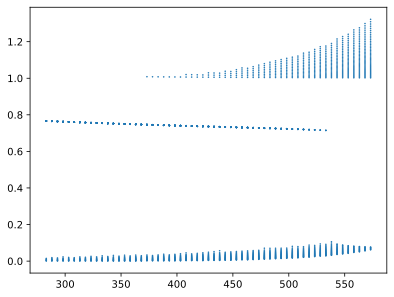

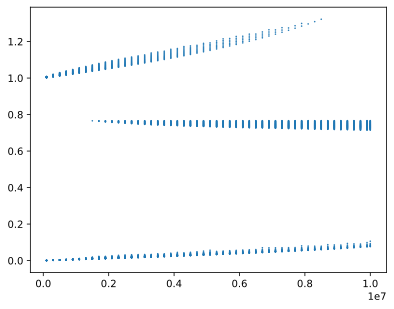

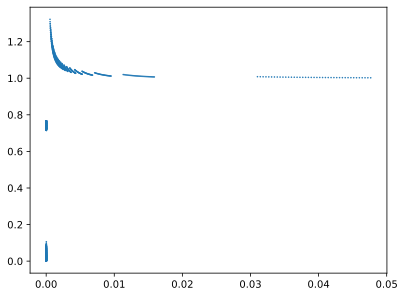

In [46]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
Tccd = TAll[0]
Thecc = ThetaAll[0]
pccd = PAll[0]
vccd = VAll[0]
plt.scatter(Tccd,Thecc,s=0.4)
plt.show()
plt.scatter(pccd,Thecc,s=0.4)
plt.show()
plt.scatter(vccd,Thecc,s=0.4)
plt.show()

In [47]:
import plotly.graph_objs as go
import plotly.offline as pyo

# 创建数据
b = np.array(vccd)
c = np.array(Tccd)
b, c = np.meshgrid(b, c)
a = np.array(Thecc)

# 创建三维图
surface = go.Surface(z=a, x=b, y=c)
layout = go.Layout(
    title='a = f(b, c)',
    scene=dict(
        xaxis=dict(title='b'),
        yaxis=dict(title='c'),
        zaxis=dict(title='a')
    )
)
fig = go.Figure(data=[surface], layout=layout)

# 显示图形
pyo.iplot(fig)

KeyboardInterrupt: 